# Imports

In [849]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as mpatches
from math import erf
from time import time,sleep
import pandas as pd
from scipy.stats import norm
import yfinance
import random
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import lognorm,norm

# Tools function with description

In [1619]:
def to_pwc(X_observed: list, cst_grid_size: int):
    """
    Converts observed prices to piece-wise constant efficient prices.

    Args:
        X_observed (list): List of observed prices.
        cst_grid_size (int): Desired length of the piece-wise constant efficient prices.

    Returns:
        list: Piece-wise constant efficient prices.

    Raises:
        Exception: If `cst_grid_size` is not a multiple of the length of `X_observed`.
    """
    X_pwc = []
    if cst_grid_size % len(X_observed) == 0:
        k = cst_grid_size / len(X_observed)
    else:
        raise Exception("cst_grid_size needs to be a multiple of the array X_obeserved")

    X_pwc.append(X_observed[0])
    for i in range(1, cst_grid_size):
        if i % k == 0:
            X_pwc.append(X_observed[int(i / k)])
        else:
            X_pwc.append(X_pwc[-1])
    return X_pwc


def previous_tick_covariation_estimator_not_optimized(pwc_path_1, pwc_path_2, h: int):
    #### First attempt to create the function, but not completely accurate ###
    """
    Computes the previous tick covariation estimator.

    Args:
        pwc_path_1 (list): Piece-wise constant efficient prices of the first path.
        pwc_path_2 (list): Piece-wise constant efficient prices of the second path.
        h (int): Estimator parameter indicating the amount of steps taken.

    Returns:
        float: Previous tick covariation estimator.

    Raises:
        Exception: If the lengths of `pwc_path_1` and `pwc_path_2` do not match.
    """
    V = 0
    if len(pwc_path_1) != len(pwc_path_2):
        raise Exception("Length mismatch between the first and second path")
    for i in range(len(pwc_path_1) // h - h):
        V += (np.log(pwc_path_1[(i + 1) * h]) - np.log(pwc_path_1[i * h])) * (
                np.log(pwc_path_2[(i + 1) * h]) - np.log(pwc_path_2[i * h]))
    return V

def previous_tick_covariation_estimator_fast(pwc_path_1, pwc_path_2, h: int):
    """
    Computes the previous tick covariation estimator.

    Args:
        pwc_path_1 (list): Piece-wise constant efficient prices of the first path.
        pwc_path_2 (list): Piece-wise constant efficient prices of the second path.
        h (int): Estimator parameter indicating the amount of steps taken.

    Returns:
        float: Previous tick covariation estimator.

    Raises:
        Exception: If the lengths of `pwc_path_1` and `pwc_path_2` do not match.
    """
    pwc_path_1_s1 = np.log(pwc_path_1[: - h:h])
    pwc_path_1_s2 = np.log(pwc_path_1[h: :h])
    
    pwc_path_2_s1 = np.log(pwc_path_2[: - h:h])
    pwc_path_2_s2 = np.log(pwc_path_2[h: :h])
    
    cn = np.sum((pwc_path_1_s2 - pwc_path_1_s1) * (pwc_path_2_s2 - pwc_path_2_s1))
    
    return cn
    
def an_func(pwc_path_1, pwc_path_2, h: int):
    """
    Computes the an_func.

    Args:
        pwc_path_1 (list): Piece-wise constant efficient prices of the first path.
        pwc_path_2 (list): Piece-wise constant efficient prices of the second path.
        h (int): Estimator parameter indicating the amount of steps taken.

    Returns:
        float: An_func.

    Raises:
        Exception: If the lengths of `pwc_path_1` and `pwc_path_2` do not match.
    """
    V = 0
    if len(pwc_path_1) != len(pwc_path_2):
        raise Exception("Length mismatch between the first and second path")
    for i in range(1, len(pwc_path_1) // h - h):
        V += abs((np.log(pwc_path_1[(i + 2) * h]) - np.log(pwc_path_1[(i + 1) * h])) * (
                np.log(pwc_path_2[(i + 1) * h]) - np.log(pwc_path_2[i * h])))
    return V

def rho_estimator(pwc_path_1, pwc_path_2, h):
    """
    Computes the rho estimator.

    Args:
        pwc_path_1 (list): Piece-wise constant efficient prices of the first path.
        pwc_path_2 (list): Piece-wise constant efficient prices of the second path.
        h (int): Estimator parameter indicating the amount of steps taken.

    Returns:
        float: Rho estimator.

    Raises:
        Exception: If the lengths of `pwc_path_1` and `pwc_path_2` do not match.
    """
    cn = previous_tick_covariation_estimator(pwc_path_1, pwc_path_2, h)
    an = an_func(pwc_path_1, pwc_path_2, h)
    if an == 0:
        return 0
    else:
        return 2 / math.pi * cn / an


def rho_estimator_fast(pwc_path_1, pwc_path_2, h):
    """
    Computes the fast rho estimator.

    Args:
        pwc_path_1 (list): Piece-wise constant efficient prices of the first path.
        pwc_path_2 (list): Piece-wise constant efficient prices of the second path.
        h (int): Estimator parameter indicating the amount of steps taken.

    Returns:
        float: Fast rho estimator.

    Raises:
        Exception: If the lengths of `pwc_path_1` and `pwc_path_2` do not match.
    """
    if len(pwc_path_1) != len(pwc_path_2):
        raise Exception("Length mismatch between the first and second path")
        
    pwc_path_1_s1 = np.log(pwc_path_1[: - 2*h:h])
    pwc_path_1_s2 = np.log(pwc_path_1[h: - h:h])
    pwc_path_1_s3 = np.log(pwc_path_1[2*h::h])    
    pwc_path_2_s1 = np.log(pwc_path_2[: - 2 *h:h])
    pwc_path_2_s2 = np.log(pwc_path_2[h: - h:h])    
    an = np.sum(np.abs((pwc_path_1_s3 - pwc_path_1_s2) * (pwc_path_2_s2 - pwc_path_2_s1)))
    
    pwc_path_1_s1 = np.log(pwc_path_1[: - h:h])
    pwc_path_1_s2 = np.log(pwc_path_1[h: :h])   
    pwc_path_2_s1 = np.log(pwc_path_2[: - h:h])
    pwc_path_2_s2 = np.log(pwc_path_2[h: :h])    
    cn = np.sum((pwc_path_1_s2 - pwc_path_1_s1) * (pwc_path_2_s2 - pwc_path_2_s1))

    if an == 0:
        return 0
    else:
        return 2 / np.pi * cn / an    


vect_rho_estimator_fast = np.vectorize(rho_estimator_fast)


def find_intersection(intervals, query):
    """Find intersections between intervals.
    Intervals are open and are represented as pairs (lower bound,
    upper bound).

    Arguments:
    intervals: array_like, shape=(N, 2) -- Array of intervals.
    query: array_like, shape=(2,) -- Interval to query.

    Returns:
    Array of indexes of intervals that overlap with query.

    """
    endpoints = np.reshape(intervals, -1)
    lower, upper = query
    i = np.searchsorted(endpoints, lower, side='right')
    j = np.searchsorted(endpoints, upper, side='left')
    return np.arange(i // 2, (j + 1) // 2)  

def HY_estimator(array1,array2):
    """
    Hayashi-Yoshida estimator with numpy functions

    Args:
        array1 (array-like): The first input array.
        array2 (array-like): The second input array.

    Returns:
        float: The estimated value 's' based on crossing intervals.

    """
    # We create the arrays of time each UZM moves
    price = np.array(array1).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array1_move = np.where(price_movement == 1)[0]
    array1_move = np.insert(array1_move , 0,0)
    price = np.array(array2).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array2_move = np.where(price_movement == 1)[0]
    array2_move = np.insert(array2_move,0,0)

    array1_log = np.log(array1)
    array2_log = np.log(array2)
    
    k=0
    s = 0
    for i in range(len(array1_move)-1):
        for j in range(len(array2_move)-1):
            I1 = (array1_log[array1_move[i]] ,array1_log[array1_move[i+1]])
            I2 = (array2_log[array2_move[j]] ,array2_log[array2_move[j+1]])
            if len(find_intersection( I1 , I2  )) == 1 :
                k+=1  # Intervals intersection is not empty
            else :
                s += (array1_log[array1_move[i+1]] - array1_log[array1_move[i]]) * (
                      array2_log[array2_move[j+1]] - array2_log[array2_move[j]])
    print("nb of time of crossing intervals",k)
    return s

def HY_estimator_optimized1(array1, array2):
    """
    Optimized Hayashi-Yoshida estimator using NumPy and Pandas.

    Args:
        array1 (array-like): The first input array.
        array2 (array-like): The second input array.

    Returns:
        float: The estimated value 's' based on crossing intervals.

    """
    # Create pandas DataFrames from input arrays
    df1 = pd.DataFrame(array1)
    df2 = pd.DataFrame(array2)

    # Find the time points where each UZM moves
    price = np.array(array1).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array1_move = np.where(price_movement == 1)[0]
    array1_move = np.insert(array1_move , 0,0)
    price = np.array(array2).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array2_move = np.where(price_movement == 1)[0]
    array2_move = np.insert(array2_move,0,0)

    # Calculate logarithms of the input arrays
    array1_log = np.log(array1)
    array2_log = np.log(array2)

    # Calculate the intersection matrix
#     intersection_matrix = np.abs(array1_log[array1_move[:-1], None] - array2_log[array2_move[:-1]]) <= np.abs(array1_log[array1_move[1:], None] - array2_log[array2_move[1:]])
    intersection_matrix = np.zeros((len(array1_move) - 1, len(array2_move) - 1), dtype=bool)

    if len(array1)<len(array2):
        I2 = list(zip(df2.loc[-1:].values, df2.shift(1).dropna().values))
#         I1 = [(array1_log[array1_move[i]] ,array1_log[array1_move[i+1]]) for i in range(len(array1_move) - 1)]
        for i in range(len(array1_move) - 1):
#             I2 = (array2_log[array2_move[j]] ,array2_log[array2_move[j+1]])
            I1 = list(zip(df1.loc[-1:].values, df1.shift(1).dropna().values))
    
            idx_ = find_intersection( I2 , I1[i]  )
            intersection_matrix[i, idx_] = True         
    else:
        I1 = list(zip(df1.loc[-1:].values, df1.shift(1).dropna().values))
#         I1 = [(array1_log[array1_move[i]] ,array1_log[array1_move[i+1]]) for i in range(len(array1_move) - 1)]
        for j in range(len(array2_move) - 1):
#             I2 = (array2_log[array2_move[j]] ,array2_log[array2_move[j+1]])
            I2 = list(zip(df2.loc[-1:].values, df2.shift(1).dropna().values))
    
            idx_ = find_intersection( I1 , I2[j]  )
            intersection_matrix[idx_, j] = True   

    #Compute the sum 's' using vectorized operations
    # s = np.sum(
    #     np.where(intersection_matrix, 0, np.matmul((np.diff(array1_log[array1_move+1])).T ,
    #              np.diff(array2_log[array2_move+1]) )

    s = np.sum(
        np.where(intersection_matrix, 0,
    np.array(pd.DataFrame((np.diff(array1_log[array1_move+1]))) @ pd.DataFrame(np.diff(array2_log[array2_move+1])).T)
    ) ) 

#     return s
    return pd.DataFrame(intersection_matrix)

def HY_estimator_optimized2(array1, array2):
    """
    Optimized Hayashi-Yoshida estimator using NumPy and Pandas.

    Args:
        array1 (array-like): The first input array.
        array2 (array-like): The second input array.

    Returns:
        float: The estimated value 's' based on crossing intervals.

    """
    # Create pandas DataFrames from input arrays
    df1 = pd.DataFrame(array1)
    df2 = pd.DataFrame(array2)

    # Find the time points where each UZM moves
    price = np.array(array1).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array1_move = np.where(price_movement == 1)[0]
    array1_move = np.insert(array1_move , 0,0)
    price = np.array(array2).T
    price_movement = price[:-1:]
    price_movement[np.diff(price , axis = 0) != 0] = 1
    array2_move = np.where(price_movement == 1)[0]
    array2_move = np.insert(array2_move,0,0)

    # Calculate logarithms of the input arrays
    array1_log = np.log(array1)
    array2_log = np.log(array2)

    # Calculate the intersection matrix
    intersection_matrix = np.abs(array1_log[array1_move[:-1], None] - array2_log[array2_move[:-1]]) <= np.abs(array1_log[array1_move[1:], None] - array2_log[array2_move[1:]])

    s = np.sum(
        np.where(intersection_matrix, 0,
    np.array(pd.DataFrame((np.diff(array1_log[array1_move+1]))) @ pd.DataFrame(np.diff(array2_log[array2_move+1])).T)
    ) ) 

#     return s
    return pd.DataFrame(intersection_matrix)

# Class with descriptions

In [1580]:
class BlackScholesModel:
    def __init__(self, spot_price, volatility, interest_rate):
        """
        Initialize the Black-Scholes model.

        Args:
            spot_price (float): The initial spot price of the underlying asset.
            volatility (float): The volatility of the underlying asset.
            interest_rate (float): The risk-free interest rate.

        """
        self.spot_price = spot_price
        self.volatility = volatility
        self.interest_rate = interest_rate

class CorrelatedBlackScholesModels:
    def __init__(self, spot_price_1, spot_price_2, volatility_1, volatility_2, interest_rate, correlation):
        """
        Initialize the Correlated Black-Scholes Models.

        Args:
            spot_price_1 (float): The initial spot price of the first underlying asset.
            spot_price_2 (float): The initial spot price of the second underlying asset.
            volatility_1 (float): The volatility of the first underlying asset.
            volatility_2 (float): The volatility of the second underlying asset.
            interest_rate (float): The risk-free interest rate.
            correlation (float): The correlation between the two underlying assets.

        """
        self.model_1 = BlackScholesModel(spot_price_1, volatility_1, interest_rate)
        self.model_2 = BlackScholesModel(spot_price_2, volatility_2, interest_rate)
        self.correlation = correlation

    def generate_correlated_paths_not_optimized(self, T, dt, seed=None):
        """
        Generate correlated paths for the two underlying assets using a not optimized approach.

        Args:
            T (float): The total time horizon.
            dt (float): The time increment.
            seed (int, optional): Seed for the random number generator. Defaults to None.

        Returns:
            tuple: A tuple containing two NumPy arrays representing the generated paths for each underlying asset.

        """
        np.random.seed(seed)
        num_steps = int(T / dt)
        path_1 = np.zeros(num_steps)
        path_1[0] = self.model_1.spot_price
        path_2 = np.zeros(num_steps)
        path_2[0] = self.model_2.spot_price
        
        for i in range(1, num_steps):
            Z1 = np.random.normal(0, 1)
            Z2 = np.random.normal(0, 1)
            drift_1 = (self.model_1.interest_rate - 0.5 * self.model_1.volatility**2) * dt
            drift_2 = (self.model_2.interest_rate - 0.5 * self.model_2.volatility**2) * dt
            diffusion_1 = self.model_1.volatility * np.sqrt(dt) * Z1
            diffusion_2 = self.model_2.volatility * np.sqrt(dt) * (self.correlation * Z1
                                                                    + np.sqrt(1 - self.correlation**2) * Z2 )
            path_1[i] = path_1[i-1] * np.exp(drift_1 + diffusion_1)
            path_2[i] = path_2[i-1] * np.exp(drift_2 + diffusion_2)
        
        return path_1, path_2
        
        
    def generate_correlated_paths(self, T, dt, seed=None):
        """
        Generates correlated paths for two Black-Scholes models.

        Args:
            T (float): The total time horizon.
            dt (float): The time increment.
            seed (int, optional): Seed for the random number generator. Defaults to None.

        Returns:
            tuple: A tuple containing two NumPy arrays representing the generated paths for each underlying asset.

        """
        np.random.seed(seed)
        num_steps = int(T / dt)
        Z1 = np.random.normal(0, 1, num_steps)
        Z2 = np.random.normal(0, 1, num_steps)

        path_1 = np.zeros(num_steps)
        path_2 = np.zeros(num_steps)
        path_1[0] = self.model_1.spot_price
        path_2[0] = self.model_2.spot_price

        drift_1 = (self.model_1.interest_rate - 0.5 * self.model_1.volatility**2) * dt
        drift_2 = (self.model_2.interest_rate - 0.5 * self.model_2.volatility**2) * dt
        diffusion_1 = self.model_1.volatility * np.sqrt(dt) * Z1
        diffusion_2 = self.model_2.volatility * np.sqrt(dt) * (self.correlation * Z1
                                                              + np.sqrt(1 - self.correlation**2) * Z2)

        path_1[1:] = path_1[0] * np.exp(drift_1 + diffusion_1.cumsum())[1:]
        path_2[1:] = path_2[0] * np.exp(drift_2 + diffusion_2.cumsum())[1:]

        return path_1, path_2


    def generate_UZ_model(self, path_1, path_2, T, dt, tick, eta, seed=None):
        """
        Generates Uncertainty Zone Models (UZMs) based on two correlated paths.

        Args:
            path_1 (ndarray): Array representing the path of the first underlying asset.
            path_2 (ndarray): Array representing the path of the second underlying asset.
            T (float): The total time horizon.
            dt (float): The time increment.
            tick (float): The tick size for defining the zones.
            eta (float): The size of the exclusion zone around each UZM.
            seed (int, optional): Seed for the random number generator. Defaults to None.

        Returns:
            tuple: A tuple containing two NumPy arrays representing the generated UZMs for each underlying asset.

        Raises:
            Exception: If an incorrect tick parameter is passed.

        """
        np.random.seed(seed)
        num_steps = int(T / dt)
        UZM_1 = np.zeros(num_steps)
        UZM_2 = np.zeros(num_steps)
        UZM_1[0] = 100
        UZM_2[0] = 100

        # For a better generalization, initialize both UZMs in the tick == condition
        # accordingly to the self.spot_price.
        if tick == 0.1:
            max_price, min_price = max(max(path_1), max(path_2)), min(min(path_1), min(path_2))
            min_tick, max_tick = round(min_price, 1), round(max_price, 1)
        elif tick == 0.5:  
            max_price, min_price = max(max(path_1), max(path_2)), min(min(path_1), min(path_2))
            min_tick, max_tick = round(2 * min_price) / 2, round(2 * max_price) / 2
        elif tick == 1:
            max_price, min_price = max(max(path_1), max(path_2)), min(min(path_1), min(path_2))
            min_tick, max_tick = round(min_price), round(max_price)
        else:
            raise Exception("Incorrect Tick parameter passed")

        all_ticks = np.arange(min_tick, max_tick + tick, tick)
        Uzones_u = np.arange(min_tick - (1 / 2 - eta - 1) * tick, max_tick + (1 / 2 - eta - 1) * tick, tick)
        Uzones_d = np.arange(min_tick - (1 / 2 + eta - 1) * tick, max_tick + (1 / 2 + eta - 1) * tick, tick)
        spot_zone = 0

        for i in range(1, num_steps):
            ## Assign new value to UZM_1
            if UZM_1[i - 1] + (1 / 2 - eta - 1) * tick < path_1[i] < UZM_1[i - 1] + (1 / 2 + eta) * tick:
                UZM_1[i] = UZM_1[i - 1]
            elif path_1[i] >= UZM_1[i - 1]:
                absolut_diff = np.maximum(Uzones_u - path_1[i], 0)
                absolut_diff[absolut_diff == 0] = 10000
                UZM_1[i] = all_ticks[np.argmin(absolut_diff)]
            else:
                absolut_diff = np.maximum(path_1[i] - Uzones_d, 0)
                absolut_diff[absolut_diff == 0] = 10000
                UZM_1[i] = all_ticks[np.argmin(absolut_diff) + 1]

            ## Assign new value to UZM_2
            if UZM_2[i - 1] + (1 / 2 - eta - 1) * tick < path_2[i] < UZM_2[i - 1] + (1 / 2 + eta) * tick:
                UZM_2[i] = UZM_2[i - 1]
            elif path_2[i] >= UZM_2[i - 1]:
                absolut_diff = np.maximum(Uzones_u - path_2[i], 0)
                absolut_diff[absolut_diff == 0] = 10000
                UZM_2[i] = all_ticks[np.argmin(absolut_diff)]
            else:
                absolut_diff = np.maximum(path_2[i] - Uzones_d, 0)
                absolut_diff[absolut_diff == 0] = 10000
                UZM_2[i] = all_ticks[np.argmin(absolut_diff) + 1]

        return UZM_1, UZM_2  #We could output the pourcentage of time the path crosses a zone

    def generate_cov_estimator(self, path_1, path_2, etas):
        """
        Generate covariance estimators for the given paths and eta values.

        Args:
            path_1 (ndarray): Path 1 values.
            path_2 (ndarray): Path 2 values.
            etas (list): List of eta values.

        Returns:
            list: A list of covariance estimators for each eta value.

        Note:
            This method relies on the `generate_UZ_model` and `previous_tick_covariation_estimator` functions.
        """
        epps = []
        for eta in etas:
            est = []
            UZM_1_eps, UZM_2_eps = self.generate_UZ_model(path_1, path_2, T, dt, tick, eta, seed=seed)
            for h in range(1, 500):
                est.append(previous_tick_covariation_estimator_fast(UZM_1_eps, UZM_2_eps, h))
            epps.append(est)
        return epps

# Simulation of 2 Correlated BS model

In [1637]:
# Parameter values
spot_price_1 = 100
spot_price_2 = 100
volatility_1 = 0.2
volatility_2 = 0.3
interest_rate = 0  #0.05
correlation = 0.7
T = 1
dt = 0.00001
seed = 123

# Create the correlated models
model = CorrelatedBlackScholesModels(spot_price_1, spot_price_2, volatility_1, volatility_2, interest_rate, correlation)
time_space = np.arange(0,T-dt,dt)

# Generate correlated paths
path_1, path_2 = model.generate_correlated_paths_not_optimized(T, dt , seed = seed)

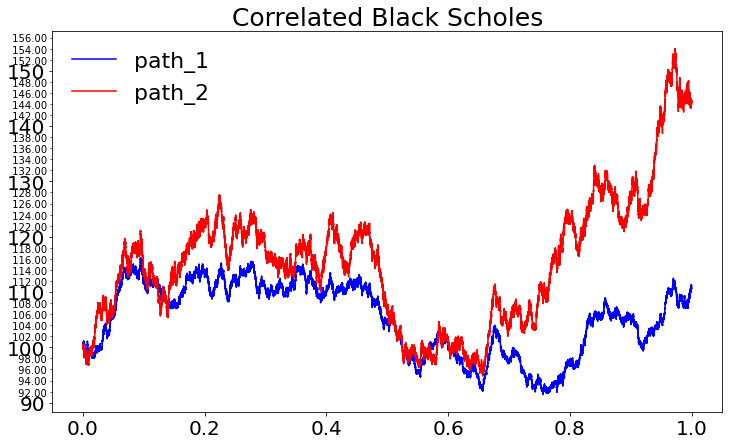

In [1638]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(time_space , path_1, label="path_1" , color = 'b')
ax.plot(time_space , path_2, label="path_2" , color = 'r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(f"Correlated Black Scholes", fontsize=25)
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter(FormatStrFormatter('% 1.2f'))
ax.legend(fontsize=22, frameon=False)
fig.savefig('Correlated Black Scholes')
plt.show()

# UZ model with BS efficient price

In [1626]:
tick   = 0.5
eta    = 0.8
UZM_1, UZM_2 = model.generate_UZ_model(path_1 , path_2 , T, dt , tick , eta , seed = seed)

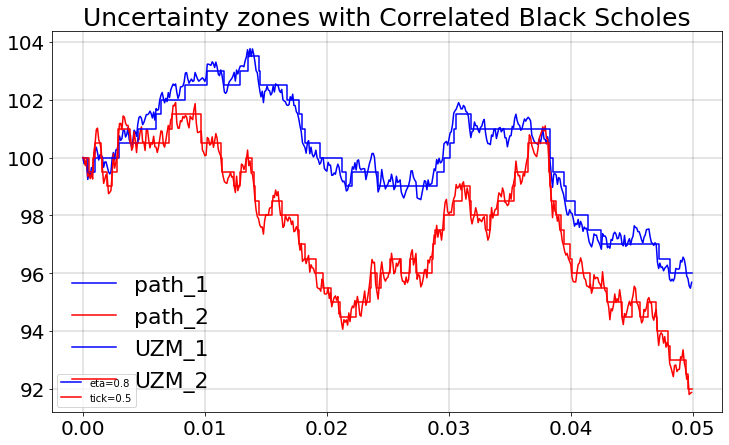

In [1628]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
nb_steps = 500
start = 0
ax.plot(time_space[start:start + nb_steps] , path_1[start:start + nb_steps], label="path_1" , color = 'b')
ax.plot(time_space[start:start + nb_steps] , path_2[start:start + nb_steps], label="path_2" , color = 'r')
ax.step(time_space[start:start + nb_steps] , UZM_1[start:start + nb_steps], label="UZM_1" , where='post' , color = 'b')
ax.step(time_space[start:start + nb_steps] , UZM_2[start:start + nb_steps], label="UZM_2" , where='pre' , color = 'r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(f"Uncertainty zones with Correlated Black Scholes", fontsize=25)
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter(FormatStrFormatter('% 1.2f'))
legend2 = plt.legend( [f"eta={eta}", f"tick={tick}"], loc=3)
ax.add_artist(legend2)
ax.legend(fontsize=22, frameon=False)
plt.grid(color='black', linestyle='-', linewidth=0.2)
#fig.savefig(f'U. zones with Correlated Black Scholes eta={eta} tick={tick} nsteps = {nb_steps}.png')
plt.show()

We observe, as expected, that $\eta$ has a big impact on the resulting UZ model. Therefore, a further study would benefit from calibrating the most adapted $\eta$ to fit the market data.

# Epps effect 

First we believe thee is no Asynchronicity of the data because we build the data from the same timeframe

Considering the efficient price $X_t$ and $Y_t$ of two assets, we want to estimate the integrated covariance : 
$$
\int_{0}^{1}\rho_t \sigma_t^X \sigma_t^Y \mathrm{d}t
$$

In [1613]:
etas = [ 0.3 , 0.8 ,  1.1 , 1.6 ,2]
epps = model.generate_cov_estimator(path_1 , path_2 , etas )

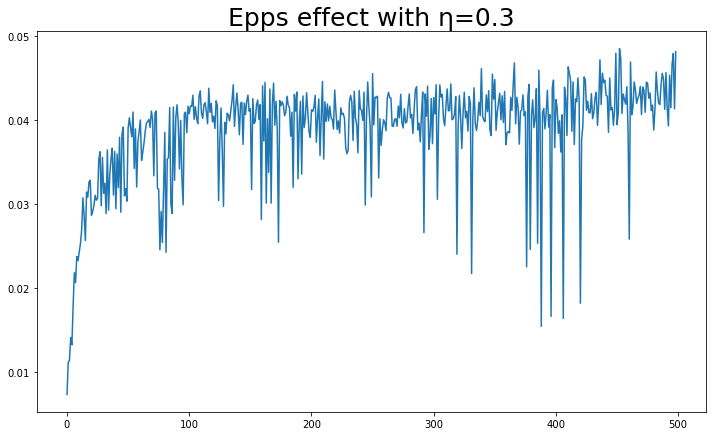

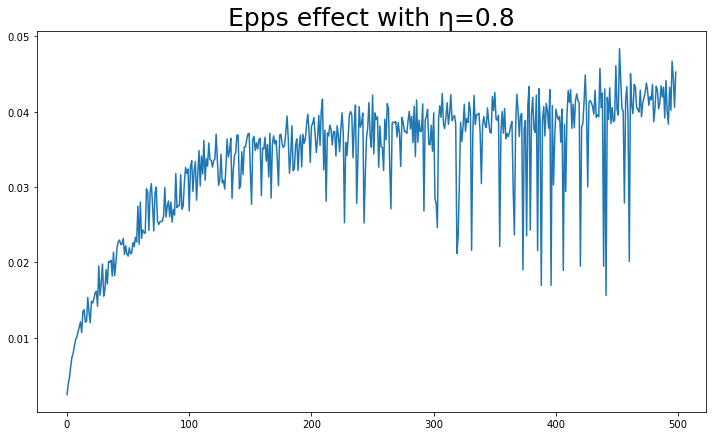

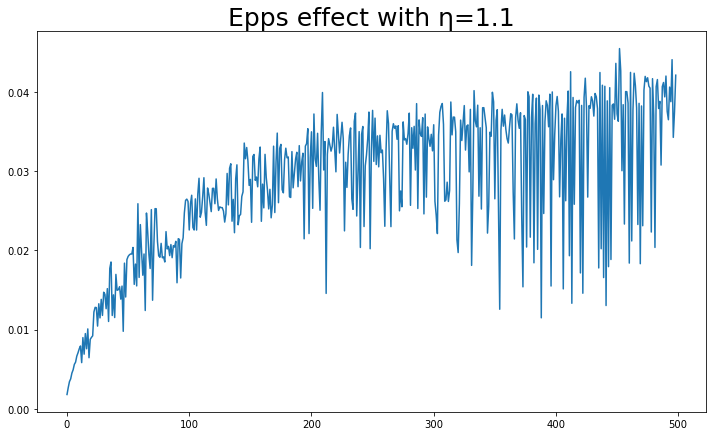

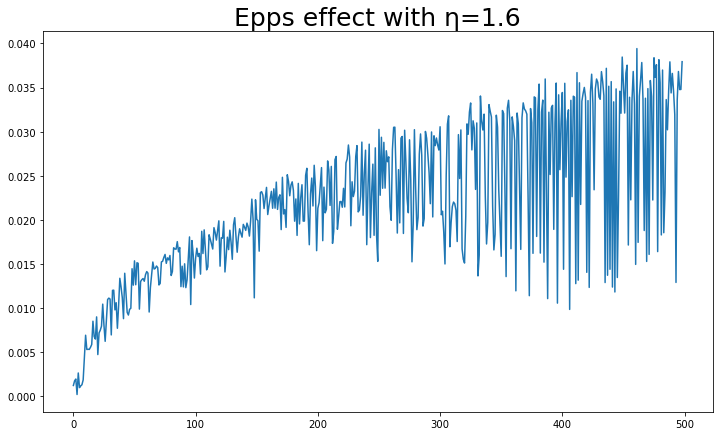

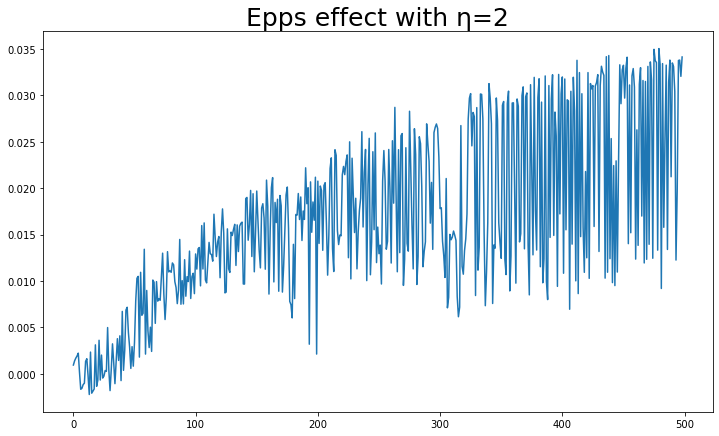

In [1599]:
for i in range(len(etas)):
    fig = plt.figure(figsize=(12,7))
    ax = plt.subplot(111)
    ax.plot(epps[i])
    ax.set_title(f"Epps effect with η={etas[i]}", fontsize=25)
    #fig.savefig(f'Epps effect with eta={etas[i]}.png')
    plt.show()

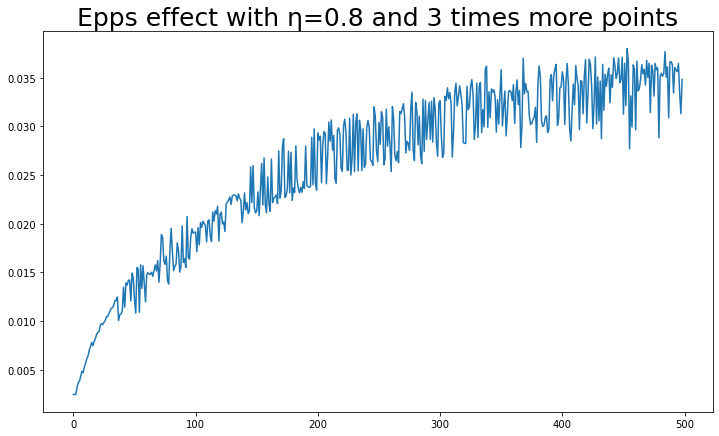

In [1600]:
est = []
allonged_UZM_1 = to_pwc(UZM_1 , 3*len(UZM_1) )
allonged_UZM_2 = to_pwc(UZM_2 , 3*len(UZM_1) )
for h in range(1,500) :
    est.append(previous_tick_covariation_estimator_fast(allonged_UZM_1 , allonged_UZM_2 , h ))

    
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(est)
ax.set_title(f"Epps effect with η=0.8 and 3 times more points", fontsize=25)
fig.savefig(f'Epps effect with eta=0.8 and 3 times more points.png')

# on allonge (zoom) pour avoir plus de data et mieux simuler la descente vers 0 de h

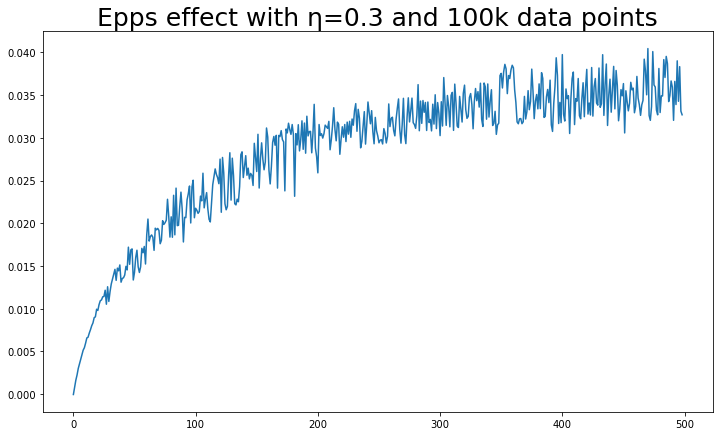

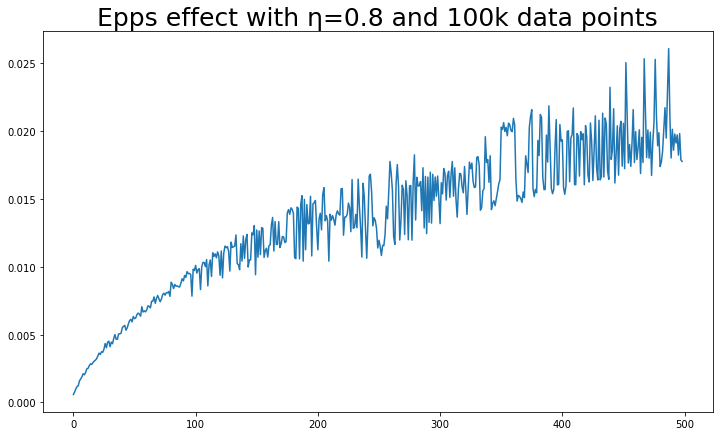

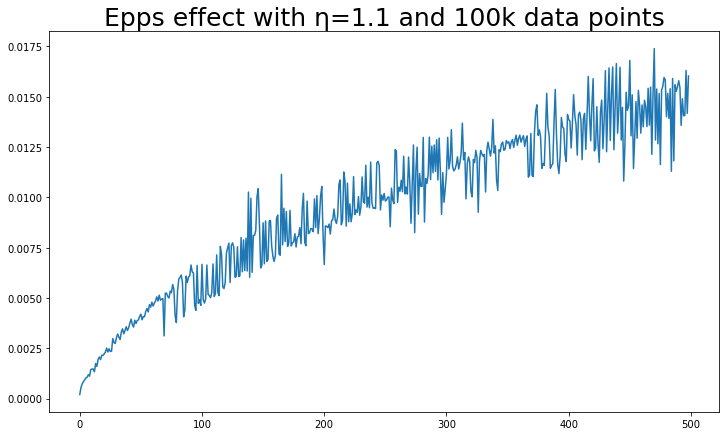

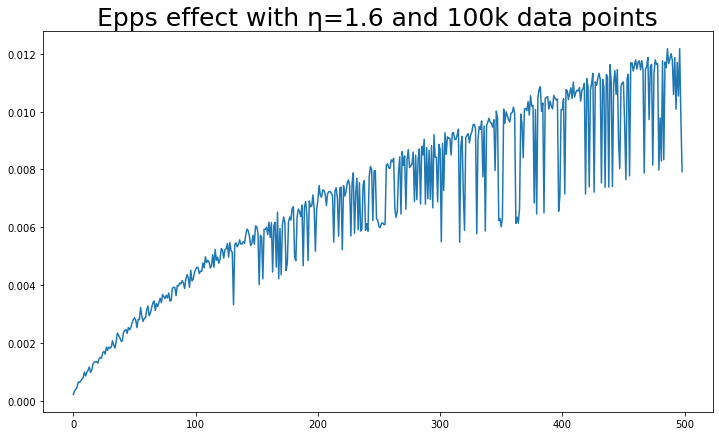

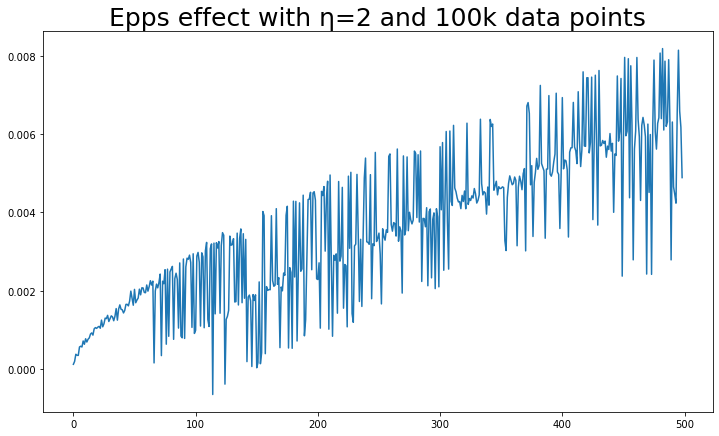

In [1612]:
for i in range(len(etas)):
    fig = plt.figure(figsize=(12,7))
    ax = plt.subplot(111)
    ax.plot(epps[i])
    ax.set_title(f"Epps effect with η={etas[i]} and 100k data points", fontsize=25)
    fig.savefig(f'Epps effect with eta={etas[i]} and 100k data points.png')
    plt.show()

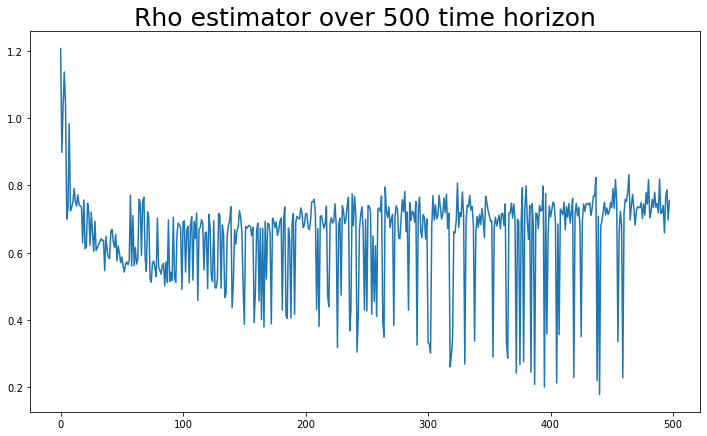

In [1604]:
rhos_prev_tick = []
for i in range(2 , 500):
    rhos_prev_tick.append(rho_estimator_fast(UZM_1 , UZM_2 , i))

fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(rhos_prev_tick)
ax.set_title(f"Rho estimator over 500 time horizon", fontsize=25)
fig.savefig(f'Rho estimator over 500 time horizon.png')

## Epps expectancy of Estimator wth MC

In [1296]:
rho_estimator_fast(UZM_1, UZM_2, 10)

0.9365042155200487

In [1294]:
rho_estimator(UZM_1, UZM_2, 10)

0.936504215520049

In [1295]:
MC_Expectancy_rho_estimator(100 , 10)

3.3886152716108877

In [1262]:
def MC_Expectancy_rho_estimator(M , h) :
    # Parameter values
    spot_price_1 = 100
    spot_price_2 = 100
    volatility_1 = 0.2
    volatility_2 = 0.3
    interest_rate = 0.05
    correlation = 0.7
    T = 1
    dt = 0.000001
#     seed = 123
    tick   = 0.5
    eta    = 2
    time_space = np.arange(0,T,dt)
    
    rho_est = 0  
    for m in range(M) :
        seed = 1000 + m #random.randint(0 , 100000)
        # Create the correlated models
        model = CorrelatedBlackScholesModels(spot_price_1, spot_price_2, volatility_1, volatility_2, interest_rate, correlation)
        # Generate correlated paths
        path_1, path_2 = model.generate_correlated_paths(T, dt , seed = seed)
        UZM_1, UZM_2 = model.generate_UZ_model(path_1 , path_2 , T, dt , tick , eta , seed = seed)
        rho = rho_estimator_fast(UZM_1, UZM_2, h)
        rho_est += rho
        #print(rho)
    return rho_est/M

In [1273]:
def MC_previous_tick_covariation_estimator_fast(M, h: int):
    # Parameter values
    spot_price_1 = 100
    spot_price_2 = 100
    volatility_1 = 0.2
    volatility_2 = 0.3
    interest_rate = 0.05
    correlation = 0.7
    T = 1
    dt = 0.000001
#     seed = 123
    tick   = 0.5
    eta    = 2
    time_space = np.arange(0,T,dt)
    
    cov_est = 0  
    for m in range(M) :
        seed = 1000 + m #random.randint(0 , 100000)
        # Create the correlated models
        model = CorrelatedBlackScholesModels(spot_price_1, spot_price_2, volatility_1, volatility_2, interest_rate, correlation)
        # Generate correlated paths
        path_1, path_2 = model.generate_correlated_paths(T, dt , seed = seed)
        UZM_1, UZM_2 = model.generate_UZ_model(path_1 , path_2 , T, dt , tick , eta , seed = seed)
        cov = previous_tick_covariation_estimator_fast(UZM_1, UZM_2, h)
        cov_est += cov
        #print(rho)
    return cov_est/M    

In [1275]:
est_cov = []
for h in range(1,300) :
    est_cov.append(MC_previous_tick_covariation_estimator_fast(100 , h ))
    print(h)
plt.plot(est_cov)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


KeyboardInterrupt: 

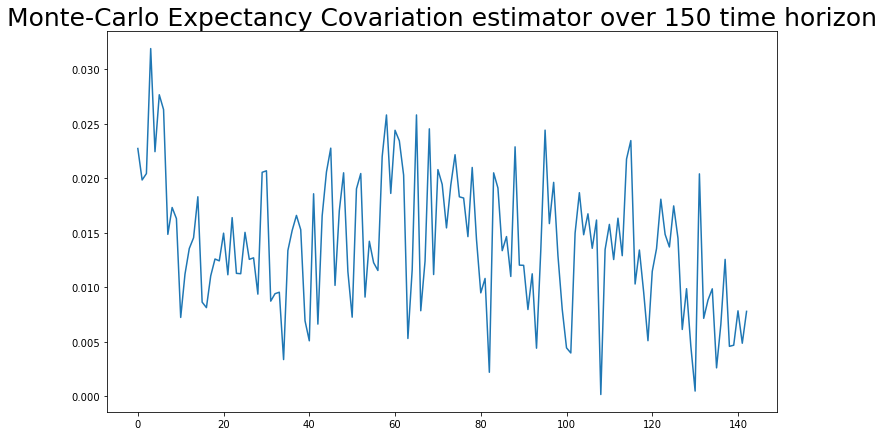

In [1605]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(est_cov)
ax.set_title(f"Monte-Carlo Expectancy Covariation estimator over 150 time horizon", fontsize=25)
fig.savefig(f'Monte-Carlo Expectancy Covariation estimator over 150 time horizo.png')

# Hayashi-Yoshida Estimator

In [1631]:
HY_estimator(UZM_1,UZM_2)

nb of time of crossing intervals 7408


-0.40981290855481417

In [1630]:
HY_estimator_optimized2(UZM_1,UZM_2)

,0,1,2,3,4,5,6,7,8,9,...,2299,2300,2301,2302,2303,2304,2305,2306,2307,2308
0,True,True,False,True,False,True,True,False,False,True,...,False,False,True,False,False,False,True,True,True,True
1,True,True,True,True,True,True,True,False,True,True,...,True,True,True,False,True,True,True,True,True,True
2,False,True,True,False,False,True,True,False,True,True,...,False,False,False,False,False,False,False,True,False,True
3,True,True,False,True,True,True,True,False,False,True,...,False,False,False,False,False,False,False,True,False,True
4,True,True,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,True,True,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1090,False,True,False,False,True,True,True,False,False,False,...,True,True,True,False,True,True,True,True,True,True
1091,True,True,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,True
1092,False,True,False,False,True,True,True,False,False,False,...,True,True,True,False,True,True,True,True,True,True


In [1629]:
HY_estimator_optimized1(UZM_1,UZM_2)

,0,1,2,3,4,5,6,7,8,9,...,2299,2300,2301,2302,2303,2304,2305,2306,2307,2308
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1090,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1091,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1092,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [1411]:
def MC_HY_estimator_efficient(M , dt = 0.0001):
    # Parameter values
    spot_price_1 = 100
    spot_price_2 = 100
    volatility_1 = 0.2
    volatility_2 = 0.3
    interest_rate = 0.05
    correlation = 0.7
    T = 1
    dt = 0.0001
    tick   = 0.5
    eta    = 2
    time_space = np.arange(0,T,dt)
    
    HY_simulation = []
    for m in range(M) :
        seed = random.randint(0,100000) + m #random.randint(0 , 100000)
        model_test = CorrelatedBlackScholesModels(spot_price_1, spot_price_2, volatility_1, volatility_2, interest_rate, correlation)
        path_1_test, path_2_test = model_test.generate_correlated_paths(T, dt , seed = seed )
        UZM_1_test, UZM_2_test = model_test.generate_UZ_model(path_1_test , path_2_test , T, dt , tick , eta , seed = seed )
        HY_simulation.append(HY_estimator(UZM_1_test , UZM_2_test))
    return HY_simulation  , np.mean(HY_simulation)

In [1633]:
MC_HY_estimator_efficient(100 , dt = 0.0001 )

nb of time of crossing intervals 10507
nb of time of crossing intervals 6297
nb of time of crossing intervals 4750
nb of time of crossing intervals 5111
nb of time of crossing intervals 2569
nb of time of crossing intervals 7664
nb of time of crossing intervals 2600
nb of time of crossing intervals 3982
nb of time of crossing intervals 3099
nb of time of crossing intervals 1513
nb of time of crossing intervals 2340
nb of time of crossing intervals 1393
nb of time of crossing intervals 2079
nb of time of crossing intervals 12036
nb of time of crossing intervals 4286
nb of time of crossing intervals 1295
nb of time of crossing intervals 5080
nb of time of crossing intervals 7486
nb of time of crossing intervals 1383
nb of time of crossing intervals 12332
nb of time of crossing intervals 6352
nb of time of crossing intervals 2480
nb of time of crossing intervals 12495
nb of time of crossing intervals 2091
nb of time of crossing intervals 943
nb of time of crossing intervals 11987
nb of ti

[1.6114044471782516,
 0.46628383627688014,
 -0.8601952026618104,
 0.2057476818175573,
 -0.02932471661803285,
 -14.46257589042093,
 0.21950343074209655,
 0.013673766512707429,
 0.9743638676135431,
 0.2727787495630975,
 -0.08414906421085715,
 0.26501089319322546,
 0.1572470456414521,
 4.2284084365927335,
 -0.6307894510078519,
 0.1889225766607519,
 0.9151232787349282,
 9.134994551224809,
 -0.009300073902330546,
 -2.9723873953333864,
 2.5388093038610466,
 1.2217931129906245,
 -14.70594233154673,
 0.5750870915424036,
 -0.04564370924912794,
 -19.942096256706478,
 -22.643463299698585,
 4.130762406496624,
 0.09422012219352088,
 -0.24941322297175877,
 0.5310104351057314,
 -7.952128879192332,
 1.0995891132252553,
 -0.6747567062769455,
 -0.18352664077383418,
 -0.04055584048320898,
 0.47051758187615156,
 0.45994453050508355,
 0.40351930098493777,
 -0.32386670860295874,
 0.9443740441536529,
 -0.09002543877011081,
 0.020982006853920772,
 1.29286650559056,
 -1.0036005985014127,
 -0.05817024642166389,

In [1634]:
u = [1.6114044471782516,
 0.46628383627688014,
 -0.8601952026618104,
 0.2057476818175573,
 -0.02932471661803285,
 -14.46257589042093,
 0.21950343074209655,
 0.013673766512707429,
 0.9743638676135431,
 0.2727787495630975,
 -0.08414906421085715,
 0.26501089319322546,
 0.1572470456414521,
 4.2284084365927335,
 -0.6307894510078519,
 0.1889225766607519,
 0.9151232787349282,
 9.134994551224809,
 -0.009300073902330546,
 -2.9723873953333864,
 2.5388093038610466,
 1.2217931129906245,
 -14.70594233154673,
 0.5750870915424036,
 -0.04564370924912794,
 -19.942096256706478,
 -22.643463299698585,
 4.130762406496624,
 0.09422012219352088,
 -0.24941322297175877,
 0.5310104351057314,
 -7.952128879192332,
 1.0995891132252553,
 -0.6747567062769455,
 -0.18352664077383418,
 -0.04055584048320898,
 0.47051758187615156,
 0.45994453050508355,
 0.40351930098493777,
 -0.32386670860295874,
 0.9443740441536529,
 -0.09002543877011081,
 0.020982006853920772,
 1.29286650559056,
 -1.0036005985014127,
 -0.05817024642166389,
 2.767721301924417,
 0.025013987304804995,
 -0.03590060718795019,
 0.5925156482701098,
 -30.471288726025783,
 -134.84090236556537,
 0.08185193279033225,
 1.4961976136041208,
 -1.9909634978772963,
 1.0860665358334225,
 -0.634613222376567,
 0.03024174470640469,
 -0.1784791564057544,
 -0.02726843306315266,
 -0.2622447334278183,
 0.3437434358730033,
 0.3930248718433799,
 0.22502888663424725,
 1.6647825915490957,
 0.20580008320691873,
 -0.23926202932724996,
 3.075074300088765,
 -0.2287637799454699,
 -0.050703453751568206,
 0.5983037134012034,
 0.339708648951592,
 -3.3561639936193832,
 -55.44903023618404,
 0.3124826782283386,
 -2.166915814940337,
 0.676428183165105,
 -0.48372502677443535,
 0.2785324886286544,
 0.2614567638013817,
 4.243336692385945,
 -0.018772668155530317,
 -0.1386278319828879,
 1.252534303690989,
 -32.89935327427617,
 0.20782457756694925,
 -0.2976055162072672,
 -0.07657603344729404,
 -0.6530801254310048,
 -2.096384362306513,
 0.059772368835599804,
 0.16238471777177613,
 2.577108711297855,
 -0.2966745620739215,
 -0.48207098825498873,
 -0.3161455712555477,
 -0.8700719418182108,
 -5.358841765614672,
 -2.1991889637294313,
 -1.0944919478615969]
np.mean(u)

-3.0878214740375154

# End